# Latent Dirichlet Allocation

The purpose of this notebook is to demonstrate how to simulate data appropriate for use with [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) to learn topics. There are a lot of moving parts involved with LDA, and it makes very strong assumptions about how word, topics and documents are distributed. In a nutshell, the distributions are all based on the [Dirichlet-Multinomial distribution](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution), and so if you understand that compound distribution, you will have an easier time understanding how to sample the topics (from the document) and the words (from the topic). At any rate, the Wikipedia site does a good enough job to enumerate the moving parts; here they are for completeness.

* $K$ is the number of topics
* $N$ is the number of words in a document; sometimes also denoted as $V$; when the number of words vary from document to document, then $N_d$ is the number of words for the $d$ document; here we assume $N$, $V$ and $N_d$ are all the same
* $M$ is the number of documents
* $\alpha$ is a vector of length $K$ on the priors of the $K$ topics; these alpha are `sparse` (less than 1)
* $\beta$ is a vector of length $N$ on the priors of the $N$ words; typically these are `symmetric` (all set to the same value e.g. 0.001)
* $\theta$ is the $M$ by $K$ matrix of document-topic (documents to topics) where each element is $P(K=k|D=d)$
* $\varphi$ is the $K$ by $V$ matrix of topic-word (topics to words) where each element is $P(W=w|K=k)$

The Wikipedia article states the sampling as follows.

$\begin{align}
\boldsymbol\varphi_{k=1 \dots K} &\sim \operatorname{Dirichlet}_V(\boldsymbol\beta) \\
\boldsymbol\theta_{d=1 \dots M} &\sim \operatorname{Dirichlet}_K(\boldsymbol\alpha) \\
z_{d=1 \dots M,w=1 \dots N_d} &\sim \operatorname{Categorical}_K(\boldsymbol\theta_d) \\
w_{d=1 \dots M,w=1 \dots N_d} &\sim \operatorname{Categorical}_V(\boldsymbol\varphi_{z_{dw}})
\end{align}$

Note the following.

* $z_{dw} \in [1 \ldots K]$ ($z_{dw}$ is an integer between 1 and $K$) and serves as a pointer back to $\varphi_k$ (the k-th row in $\varphi$ that you will use as priors to sample the words)
* $w_{dw} \in [1 \ldots N]$ ($w_{dw}$ is an integer between 1 and $N$) which is the n-th word
* $z_{dw}$ is actually sampled from $\operatorname{Multinomial}(\boldsymbol\theta_d)$ taking the arg max, e.g. $z_{dw} \sim \underset{\theta_d}{\operatorname{arg\,max}}\ \operatorname{Multinomial}(\boldsymbol\theta_d)$
* $w_{dw}$ is actually sampled from $\operatorname{Multinomial}(\boldsymbol\varphi_{z_{dw}})$ taking the arg max, e.g. $z_{dw} \sim \underset{\boldsymbol\varphi_{w_{dw}}}{\operatorname{arg\,max}}\ \operatorname{Multinomial}(\boldsymbol\varphi_{z_{dw}})$

The code below should make it clear as there are a lot of sub-scripts and moving parts.

## Simulate the data

Let's get ready to sample. Note the following.

* $K = 10$ (ten topics)
* $N = 100$ (one hundred words)
* $M = 1000$ (one thousand documents)
* $\alpha = [0.1, 0.2, 0.3, 0.4, 0.025, 0.015, 0.37, 0.88, 0.03, 0.08]$ (10 sparse priors on topics)
* $\beta = [0.001 \ldots 0.001]$ (100 symetric priors on words)

Below, we store the sampled documents and associated words in

* `texts` as string literal (e.g. w1 w1 w83 ....)
* `docs` as a dictionary of counts (e.g. { 1: 2, 83: 1, ...})

The matrices

* `C` stores the counts
* `X` stores the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) values

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import dirichlet, multinomial
from scipy.sparse import lil_matrix
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

np.random.seed(37)

# number of topics
K = 10
# number of words
N = 100
# number of documents
M = 1000

# priors on K topics
a = np.array([0.1, 0.2, 0.3, 0.4, 0.025, 0.015, 0.37, 0.88, 0.03, 0.08])
# priors on N words
b = np.full((1, N), 0.001, dtype=float)[0]

# distribution of words in topic k
phi = np.array([dirichlet.rvs(b)[0] for _ in range(K)])

# distribution of topics in document d
theta = np.array([dirichlet.rvs(a)[0] for _ in range(M)])

# simulate the documents
texts = []
docs = []

# for each document
for i in range(M):
    d = {}
    t = []
    
    # for each word
    for j in range(N):
        # sample the possible topics
        z_ij = multinomial.rvs(1, theta[i])
        # get the identity of the topic; the one with the highest probability
        topic = np.argmax(z_ij)
        
        # sample the possible words from the topic
        w_ij = multinomial.rvs(1, phi[topic])
        # get the identity of the word; the one with the highest probability
        word = np.argmax(w_ij)
        
        if word not in d:
            d[word] = 0
        d[word] = d[word] + 1
        t.append('w{}'.format(word))
    docs.append(d)
    texts.append(' '.join(t))

# make a nice matrix
# C is a matrix of word counts (rows are documents, columns are words, elements are count values)
C = lil_matrix((M, N), dtype=np.int16)
for i, d in enumerate(docs):
    counts = sorted(list(d.items()), key=lambda tup: tup[0])
    for tup in counts:
        C[i, tup[0]] = tup[1]

# X is a matrix of tf-idf (rows are documents, columns are words, elements are tf-idf values)
X = TfidfTransformer().fit_transform(C)

## Gaussian mixture models (GMMs)

Let's see if GMMs can help us recover the number of topics using the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) score to guide us.

In [2]:
from scipy.sparse.linalg import svds
from sklearn.mixture import GaussianMixture

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=200, random_state=37)
    gmm.fit(X)
    aic = gmm.aic(X)
    print('{}: aic={}'.format(k, aic))
    return k, aic

U, S, V = svds(X, k=20)
gmm_scores = [get_gmm_labels(U, k) for k in range(2, 26)]

2: aic=-91377.4925931899
3: aic=-115401.48064693023
4: aic=-140093.33933540556
5: aic=-140323.78987370015
6: aic=-141875.7608870883
7: aic=-148775.55233751616
8: aic=-144864.34044251204
9: aic=-145063.4922621106
10: aic=-150715.19037699007
11: aic=-152996.5234889565
12: aic=-155759.24880410862
13: aic=-154738.52657589084
14: aic=-155298.3570419242
15: aic=-155273.86266190943
16: aic=-158229.54424744606
17: aic=-158801.92826365907
18: aic=-158146.93107164893
19: aic=-157399.88209837917
20: aic=-158964.20247723104
21: aic=-156443.29839085325
22: aic=-156545.28924475564
23: aic=-156265.51016605442
24: aic=-155860.4914350854
25: aic=-157396.56289736537


## k-means clustering (KMC)

Let's see if KMC can help us to recover the number of topics using the [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_%28clustering%29) to guide us.

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_kmc(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    print('{}: score={}'.format(k, score))
    return k, score

kmc_scores = [get_kmc(X, k) for k in range(2, 26)]

2: score=0.22136552497539078
3: score=0.2606191325546754
4: score=0.2985364557161296
5: score=0.32764563696557253
6: score=0.34711980577628615
7: score=0.36212754809252495
8: score=0.3693035922796191
9: score=0.3118628444238988
10: score=0.32070416934016466
11: score=0.3056882384904699
12: score=0.28297903762485543
13: score=0.28462816984240946
14: score=0.2747613933318139
15: score=0.2787478862359055
16: score=0.27452088253304896
17: score=0.2548015324435892
18: score=0.25961952207924777
19: score=0.25650479556223627
20: score=0.251690199350559
21: score=0.2566617758778615
22: score=0.25866268014756943
23: score=0.24607465357359543
24: score=0.24936289940720038
25: score=0.2579644562276278


## LDA modeling

Here, we will use LDA topic modeling technique and the [coherence score](https://radimrehurek.com/gensim/models/coherencemodel.html) to guide us recovering the number of topics.

In [4]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def learn_lda_model(corpus, dictionary, k):
    lda = LdaModel(corpus, 
               id2word=dictionary, 
               num_topics=k, 
               random_state=37, 
               iterations=100,
               passes=5,
               per_word_topics=False)
    cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print('{}: {}'.format(k, coherence))
    return k, coherence

T = [t.split(' ') for t in texts]

dictionary = corpora.Dictionary(T)
corpus = [dictionary.doc2bow(text) for text in T]

lda_scores = [learn_lda_model(corpus, dictionary, k) for k in range(2, 26)]

2: -7.112621491925517
3: -6.770771537876562
4: -6.654850158110881
5: -6.495525290205532
6: -6.592127872424598
7: -6.4394384370150854
8: -6.431505215171467
9: -6.376827700591723
10: -6.207008469326988
11: -6.235774265382583
12: -6.289107652710713
13: -6.254881861190534
14: -6.550148968159432
15: -6.6008249817300415
16: -6.560176401338963
17: -6.607477085524114
18: -6.707151535098344
19: -6.712047152650457
20: -6.723101440691804
21: -6.906780797634873
22: -6.6622351856878375
23: -6.773847370134338
24: -6.735329093161339
25: -6.676802294304821


## Visualize the techniques and scores versus the number of topics

Here, we visualize the scores (GMM AIC, KMC Silhouette and LDA Coherence) versus the number of topics (k). For AIC, the lower the score, the better; for silhouette, the higher the better; for coherence, the higher the better. It seems that KCM's silhouette does not really agree with AIC or coherence; and AIC and coherence (although negative correlated) seem to hint at the same number of topics.

When relying on LDA and coherence, k=10 is the highest, as we'd expect since we simulated the data from 10 latent/hidden topics.

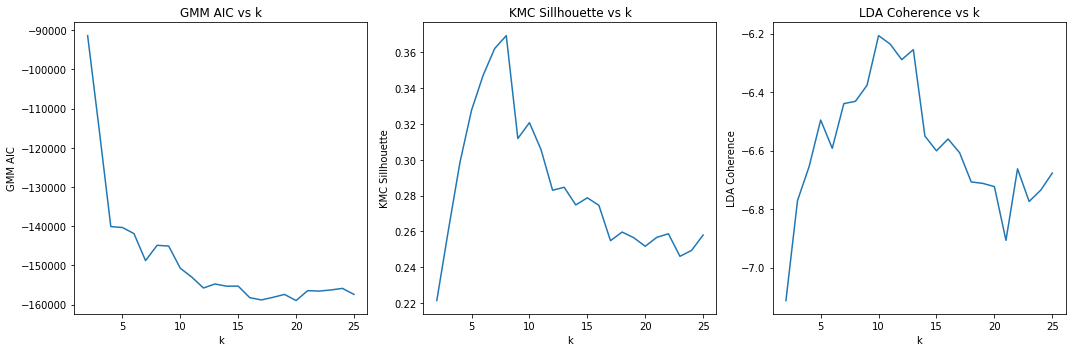

In [5]:
def plot_scores(scores, ax, ylabel):
    _x = [s[0] for s in scores]
    _y = [s[1] for s in scores]

    ax.plot(_x, _y, color='tab:blue')
    ax.set_xlabel('k')
    ax.set_ylabel(ylabel)
    ax.set_title('{} vs k'.format(ylabel))
    
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_scores(gmm_scores, ax[0], 'GMM AIC')
plot_scores(kmc_scores, ax[1], 'KMC Sillhouette')
plot_scores(lda_scores, ax[2], 'LDA Coherence')

plt.tight_layout()

## Visualize the topics

This visualization tool allows us to `interrogate` the topics. As we hover over each topic, the words most strongly associated with them are show.

In [ ]:
import pyLDAvis.gensim
import warnings

warnings.filterwarnings('ignore')

lda = LdaModel(corpus, 
               id2word=dictionary, 
               num_topics=10, 
               random_state=37, 
               iterations=100,
               passes=5,
               per_word_topics=False)

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Close to real-world example

Here's a list of 10 book titles when searching on `programming` and `economics` from Amazon (5 each). Again, when the number of topics is k=2, that model has the highest coherence score.

In [7]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer

def clean(text):
    t = text.lower().strip()
    t = t.split()
    t = remove_stop_words(t)
    t = [get_lemma(w) for w in t]
    t = [get_stem(w) for w in t]
    return t

def get_stem(w):
    return PorterStemmer().stem(w)
    
def get_lemma(w):
    lemma = wn.morphy(w)
    return w if lemma is None else lemma
    
def remove_stop_words(tokens):
    stop_words = nltk.corpus.stopwords.words('english')
    return [token for token in tokens if token not in stop_words]


texts = [
    'The Art of Computer Programming',
    'Computer Programming Learn Any Programming Language In 2 Hours',
    'The Self-Taught Programmer The Definitive Guide to Programming Professionally',
    'The Complete Software Developers Career Guide How to Learn Your Next Programming Language',
    'Cracking the Coding Interview 189 Programming Questions and Solutions',
    'The Economics Book Big Ideas Simply Explained',
    'Economics in One Lesson The Shortest and Surest Way to Understand Basic Economics',
    'Basic Economics',
    'Aftermath Seven Secrets of Wealth Preservation in the Coming Chaos',
    'Economics 101 From Consumer Behavior to Competitive Markets Everything You Need to Know About Economics'
]

texts = [clean(t) for t in texts]

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_scores = [learn_lda_model(corpus, dictionary, k) for k in range(2, 10)]

2: -26.8263021597115
3: -26.863492751597203
4: -26.88208804754005
5: -26.848616514842924
6: -26.9006833434829
7: -26.874118634993117
8: -26.88208804754005
9: -26.863492751597203


Learn the model with 2 topics.

In [8]:
lda = LdaModel(corpus, 
               id2word=dictionary, 
               num_topics=2, 
               random_state=37, 
               iterations=100,
               passes=20,
               per_word_topics=False)

Print what the model predicts for each book title. Note the 9-th book title is a tie (50/50)? Otherwise, all the predictions (based on highest probabilities) are correct.

In [9]:
corpus_lda = lda[corpus]

for d in corpus_lda:
    print(d)

[(0, 0.25178078), (1, 0.7482192)]
[(0, 0.16788824), (1, 0.8321117)]
[(0, 0.25178385), (1, 0.74821615)]
[(0, 0.25177962), (1, 0.7482204)]
[(0, 0.2517812), (1, 0.7482188)]
[(0, 0.7482479), (1, 0.25175208)]
[(0, 0.83213073), (1, 0.16786925)]
[(0, 0.74824756), (1, 0.2517524)]
[(0, 0.5), (1, 0.5)]
[(0, 0.8321298), (1, 0.16787016)]


The first topic is about `econom` (economics) and the second about `programming`, as we'd expect. Observe how each topic has a little of the other's words? This observation is the result of the assumption from LDA that documents are a mixture of topics and topics have distributions over words.

In [10]:
lda.print_topics()

[(0, '0.926*"econom" + 0.074*"program"'),
 (1, '0.926*"program" + 0.074*"econom"')]

This book title is a `holdout` title from the economics search result. It is correctly placed in the 0-th topic (economics).

In [11]:
lda[dictionary.doc2bow(clean('Naked Economics Undressing the Dismal Science'))]

[(0, 0.74824804), (1, 0.25175193)]

This book title is a `holdout` title from the programming search result. It is correctly placed in the 1-st topic (programming).

In [12]:
lda[dictionary.doc2bow(clean('Elements of Programming Interviews in Python The Insiders Guide'))]

[(0, 0.25178164), (1, 0.74821836)]

Since this example is trivial, the visualization is not very interesting, but displayed below anyways.

In [ ]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)